In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.crescent import *

In [2]:
folder = "./data/2023_02_06_Altinget/pupils"
# img name regex: "0000_H/V_L/R.png"
regex = re.compile(r"(?:\d{4})_(?:H|V)_(?:L|R).png")
filelist = os.listdir(folder)

im_train = []
mask_train = []

for filename in filelist:
    if filename.endswith(".png"):
        name = filename.split(".")[0]
        if regex.match(filename):
            if f"{name}_mask.png" in filelist:
                img = cv2.imread(f"{folder}/{filename}")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = cv2.imread(f"{folder}/{name}_mask.png", cv2.IMREAD_GRAYSCALE)
                im_train.append(img)
                mask_train.append(mask)

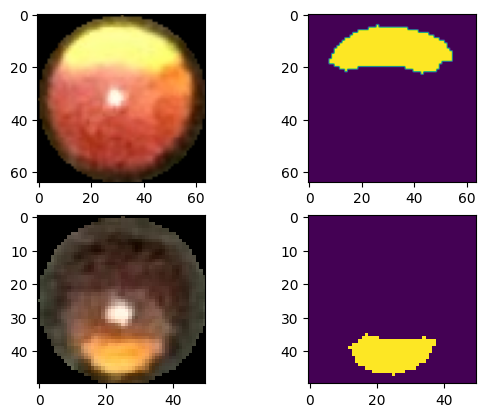

In [3]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(im_train[0])
ax[0, 1].imshow(mask_train[0])
ax[1, 0].imshow(im_train[1])
ax[1, 1].imshow(mask_train[1])

In [4]:
num_samples_per_img = 1000
num_features = 10

X = np.zeros((len(im_train)*num_samples_per_img, num_features))
y = np.zeros(len(im_train)*num_samples_per_img)

In [5]:
for i, img in enumerate(im_train):
    features = get_features(img)
    flat_img = img.reshape(-1, 3)
    flat_mask = mask_train[i].reshape(-1)
    flat_mask = (flat_mask > 0).astype(int)
    # flatten features
    features = features.reshape(features.shape[0], -1)
    samples = np.random.choice(flat_img.shape[0], num_samples_per_img)
    X[i*num_samples_per_img:(i+1)*num_samples_per_img] = features[:, samples].T
    y[i*num_samples_per_img:(i+1)*num_samples_per_img] = flat_mask[samples]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
model = SVC()
model.fit(X, y)

SVC()

In [8]:
yhat = model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 94.96%


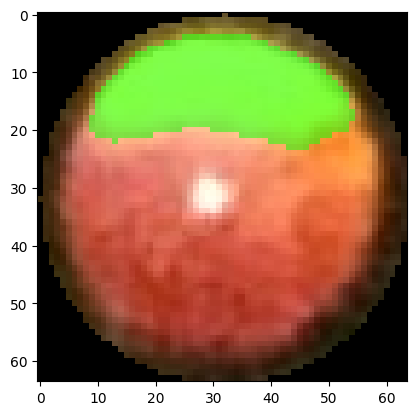

In [9]:
# draw mask on image with alpha
mask = get_mask(im_train[0], model)
alpha = 0.5
overlay = im_train[0].copy()
output = im_train[0].copy()
overlay[mask > 0] = (0, 255, 0)
cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)
plt.imshow(output)

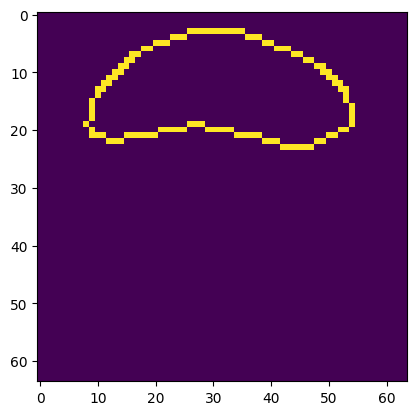

In [10]:
# get border of mask
border = mask.copy()
border = cv2.Canny(border.astype(np.uint8), 0, 1)
plt.imshow(border)

In [11]:
name = "data\\2023_02_06_Altinget\\2023_02_06_Altinget\\0091_V.HEIC"
img = cv2.imread(name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [12]:
from utils.segmentation import pipe as seg_pipe

In [13]:
right_pupil, left_pupil = seg_pipe(img)

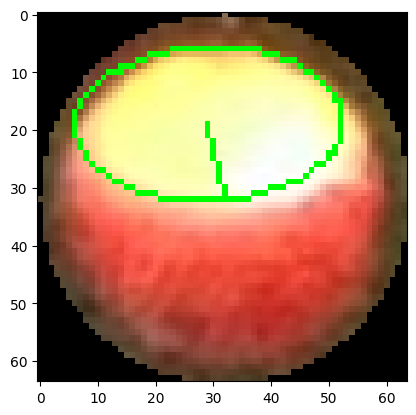

In [14]:
img = right_pupil.copy()
mask = get_mask(img, model)
border = mask.copy()
border = cv2.Canny(border.astype(np.uint8), 0, 1)
border_points = np.argwhere(border)
border_points = border_points[:, ::-1]
best_ellipse = ransac_ellipse(border_points.tolist(), 5000, 6.0)
# draw ellipse on image
output = img.copy()
cv2.ellipse(output, best_ellipse, (0, 255, 0), 1)
# draw a line from center of ellipse to center of image
center = (int(best_ellipse[0][0]), int(best_ellipse[0][1]))
cv2.line(output, center, (img.shape[1]//2, img.shape[0]//2), (0, 255, 0), 1)
plt.imshow(output)

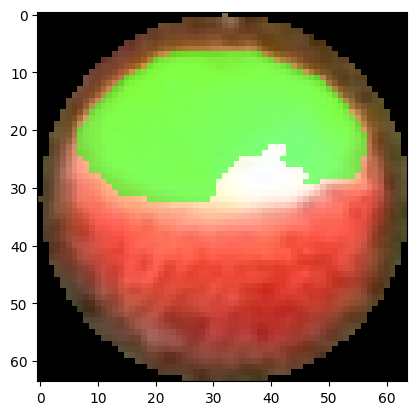

In [15]:
mask = get_mask(img, model)
alpha = 0.5
overlay = img.copy()
prediction = img.copy()
overlay[mask > 0] = (0, 255, 0)
cv2.addWeighted(overlay, alpha, prediction, 1 - alpha, 0, prediction)
plt.imshow(prediction)

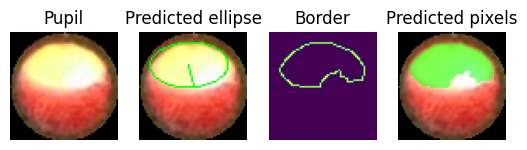

In [16]:
# create figure with 4 subplots
# 1. original image, 2. mask, 3. border, 4. overlay
fig, ax = plt.subplots(1, 4)
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Pupil")
ax[1].imshow(output)
ax[1].set_title("Predicted ellipse")
ax[1].axis("off")
ax[2].imshow(border)
ax[2].set_title("Border")
ax[2].axis("off")
ax[3].imshow(prediction)
ax[3].set_title("Predicted pixels")
ax[3].axis("off")

plt.show()

In [17]:
pipe(img, model, orientation='V')

(21.339206403476773, -7.293752380205268, 1)

In [ ]:
# save model
import pickle
with open("./models/crescent_segmenter.pkl", "wb") as f:
    pickle.dump(model, f)

